<a href="https://colab.research.google.com/github/andresFelipeGiraldoYusti/PROYECTO_MODELOS_II_eeg-eye-state/blob/main/notebooks/models/MODELO_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALAR LIBRERIAS

In [ ]:
!pip install -q liac-arff pandas

  Preparing metadata (setup.py) ... done


# EXPORTAR LIBRERIAS

In [ ]:
from scipy.io import arff
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
import time
from sklearn.neural_network import MLPClassifier

# CARGAR LOS DATOS

In [ ]:
# === 1. Montar Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === 3. Importar librerías ===
import arff
import pandas as pd
import os # Import the os module

# === 4. Definir la ruta del archivo ARFF ===
ruta = "/content/drive/MyDrive/Practica_MODELOS_II/data/phplE7q6h.arff"

# === 5. Verificar la existencia del archivo ===
if not os.path.exists(ruta):
    print(f"❌ Error: El archivo no se encontró en la ruta: {ruta}")
else:
    # === 6. Cargar el archivo ARFF ===
    with open(ruta, "r", encoding="utf-8") as f:
        arff_data = arff.load(f)

    # Extraer nombres de columnas
    columnas = [attr[0] for attr in arff_data['attributes']]

    # Crear DataFrame con pandas
    df = pd.DataFrame(arff_data['data'], columns=columnas)

    # === 7. Mostrar información básica ===
    print("✅ Archivo cargado correctamente")
    print("Dimensiones:", df.shape)
    print("Columnas:", columnas[:15], "..." if len(columnas) > 15 else "")

Mounted at /content/drive
✅ Archivo cargado correctamente
Dimensiones: (14980, 15)
Columnas: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'Class'] 


# Estandarizar los datos

In [ ]:
def estandarizar_datos(X_train, X_test):


    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    return X_train_std, X_test_std, scaler

# Seleccion y extraccion de caracteristicas

## LASSO



In [ ]:
def seleccion_caracteristicas_lasso(X_train, y_train, X_test, alpha=0.01):
    from sklearn.linear_model import Lasso
    from sklearn.feature_selection import SelectFromModel
    import numpy as np

    # 1. Ajustar modelo LASSO para seleccionar características
    lasso = Lasso(alpha=alpha)
    selector = SelectFromModel(lasso)
    selector.fit(X_train, y_train)

    # 2. Transformación usando características seleccionadas
    X_train_sel = selector.transform(X_train)
    X_test_sel = selector.transform(X_test)

    # 3. Mostrar información ANTES del return
    print("=== INFORMACIÓN DE LASSO ===")

    # máscara booleana de características seleccionadas
    mask = selector.get_support()

    # Si X_train tiene nombres de columnas
    if hasattr(X_train, "columns"):
        feature_names = np.array(X_train.columns)
    else:
        feature_names = np.array([f"feature_{i}" for i in range(X_train.shape[1])])

    selected_features = feature_names[mask]
    removed_features = feature_names[~mask]

    print("\nCaracterísticas seleccionadas:")
    print(selected_features)

    print("\nCaracterísticas eliminadas:")
    print(removed_features)

    # Ajustar Lasso nuevamente para ver coeficientes
    lasso.fit(X_train, y_train)
    print("\nCoeficientes del modelo LASSO:")
    print(lasso.coef_)

    print("\nNúmero de características antes:", X_train.shape[1])
    print("Número de características después:", X_train_sel.shape[1])
    print("=" * 40)

    # 4. Retornar exactamente lo mismo que antes
    return X_train_sel, X_test_sel, selector



# PCA

In [ ]:
def reduccion_dimensional_pca(X_train, X_test, n_components=0.95):
    """
    Aplica PCA para reducción de dimensionalidad.

    Parámetros:
    - X_train, X_test: datos de entrenamiento y prueba
    - n_components: cantidad de componentes (float <1 = varianza explicada, int = número fijo)

    Retorna:
    - X_train_sel, X_test_sel: datos transformados
    - pca: objeto PCA ajustado
    """
    from sklearn.decomposition import PCA
    import numpy as np

    # Ajustar PCA
    pca = PCA(n_components=n_components)
    X_train_sel = pca.fit_transform(X_train)
    X_test_sel = pca.transform(X_test)

    # Información
    print("=== INFORMACIÓN DE PCA ===")
    print("Número de características antes:", X_train.shape[1])
    print("Número de características después:", X_train_sel.shape[1])
    print("Varianza explicada por componente:", pca.explained_variance_ratio_)
    print("="*40)

    return X_train_sel, X_test_sel, pca

# Validacion cruzada

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import time

# Transformador personalizado para LASSO
class LassoSelector(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.lasso = Lasso(alpha=self.alpha)
        self.support_mask = None

    def fit(self, X, y=None):
        self.lasso.fit(X, y)
        self.support_mask = self.lasso.coef_ != 0
        return self

    def transform(self, X):
        return X[:, self.support_mask]

# Función actualizada de validación cruzada
def validar_modelo_cv(modelo, X, y, metric='accuracy', cv=5, alpha=0.01):
    """
    Valida un solo modelo usando validación cruzada con normalización y selección de características LASSO.

    Parámetros:
    - modelo: modelo sklearn ya instanciado
    - X, y: datos sin procesar (DataFrame o array)
    - metric: métrica a evaluar ('accuracy', 'f1', 'roc_auc', etc.)
    - cv: número de folds
    - alpha: parámetro LASSO para la selección de características

    Retorna:
    - diccionario con promedio, desviación estándar y tiempo de entrenamiento
    """
    # Convertir X a numpy si es DataFrame
    X_array = X.values if hasattr(X, 'values') else X

    # Crear pipeline: Escalado + LASSO + modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso', LassoSelector(alpha=alpha)),
        ('model', modelo)
    ])

    # Configurar validación cruzada estratificada
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    start_time = time.time()
    scores = cross_val_score(pipeline, X_array, y, scoring=metric, cv=skf)
    end_time = time.time()

    resultado = {
        'Promedio': np.mean(scores),
        'Desviacion': np.std(scores),
        'Tiempo_entrenamiento': end_time - start_time
    }

    return resultado


# SEPARAR LOS DATOS

In [ ]:
data_train = 0.8
data_test = 0.1
data_val = 0.1
random_state = 42

x = df.drop('Class', axis=1)
y = df['Class']

X_train, X_temp, y_train, y_temp = train_test_split(
    x, y, test_size=data_test+data_val, random_state=random_state, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Se estandarizan los datos

In [ ]:
# 1. Estandarizar
X_train_std, X_test_std, scaler = estandarizar_datos(X_train, X_test)

# 2. Seleccionar características
X_train_sel, X_test_sel, selector = reduccion_dimensional_pca(
    X_train_std, X_test_std, n_components=0.95)

=== INFORMACIÓN DE PCA ===
Número de características antes: 14
Número de características después: 5
Varianza explicada por componente: [0.31311556 0.29817667 0.22579857 0.09115685 0.03432555]


# HIPERPARAMETROS DEL MODELO

In [ ]:
# ============HIPERPARAMETROS MODELO SVM===============================
hiden_layer_sizes_values = [(100,), (50, 50), (100, 50)]

alpha_values = [0.0001, 0.001, 0.01]

kernel_values = ['relu']
activation_values = ['relu'] # tanh

# ==========================================================

# INICIALIZACION DE MATRICES

In [ ]:
accuaracy_matrix = np.zeros((len(alpha_values), len(hiden_layer_sizes_values)))
precision_matrix = np.zeros((len(alpha_values), len(hiden_layer_sizes_values)))
recall_matrix = np.zeros((len(alpha_values), len(hiden_layer_sizes_values)))
f1_matrix = np.zeros((len(alpha_values), len(hiden_layer_sizes_values)))
train_time_matrix = np.zeros((len(alpha_values), len(hiden_layer_sizes_values)))
conf_matrices = {}
modelos_dict = {}

# PROCESO DE ENTRENAMIENTO Y PREDICCION

In [ ]:
for i in kernel_values:
    print(f"{'='*10}{i}{'='*10}")
    for j, alpha in enumerate(alpha_values):
        for k, hiden_layer_sizes in enumerate(hiden_layer_sizes_values):
            # ============Generar MODELO===============================
            model_svm = MLPClassifier(hidden_layer_sizes=hiden_layer_sizes, activation=i, alpha=alpha)
            # ==========================================================

            start_time = time.perf_counter()
            model_svm.fit(X_train,y_train)
            end_time = time.perf_counter()
            y_val_pred = model_svm.predict(X_val)
            report = classification_report(y_val, y_val_pred, output_dict=True)

            accuracy = accuracy_score(y_val, y_val_pred)
            presicion = report['macro avg']['precision']
            recall = report['macro avg']['recall']
            f1 = report['macro avg']['f1-score']
            train_time = end_time - start_time
            conf = confusion_matrix(y_val, y_val_pred)
            key = f'activate={i}_alpha={alpha}_hiden_layer_sizes={hiden_layer_sizes}'
            modelos_dict[key] = model_svm


            precision_matrix[j, k] = presicion
            recall_matrix[j, k] = recall
            f1_matrix[j, k] = f1
            accuaracy_matrix[j,k] = accuracy
            train_time_matrix[j, k] = train_time
            conf_matrices[(alpha, hiden_layer_sizes)] = conf
            print(f"C={hiden_layer_sizes}, alpha={alpha}, acc={accuracy:.4f}")

==========relu==========
C=(100,), alpha=0.0001, acc=0.5234
C=(50, 50), alpha=0.0001, acc=0.4533


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C=(100, 50), alpha=0.0001, acc=0.5507
C=(100,), alpha=0.001, acc=0.5527
C=(50, 50), alpha=0.001, acc=0.5247
C=(100, 50), alpha=0.001, acc=0.5494


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C=(100,), alpha=0.01, acc=0.5507


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


C=(50, 50), alpha=0.01, acc=0.5507
C=(100, 50), alpha=0.01, acc=0.5507


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# IMPRIMIR MATRICES

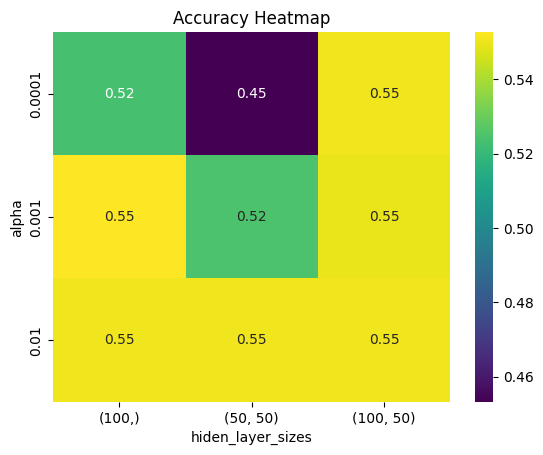

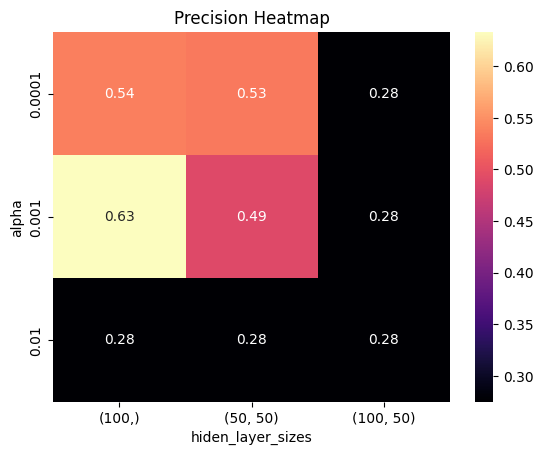

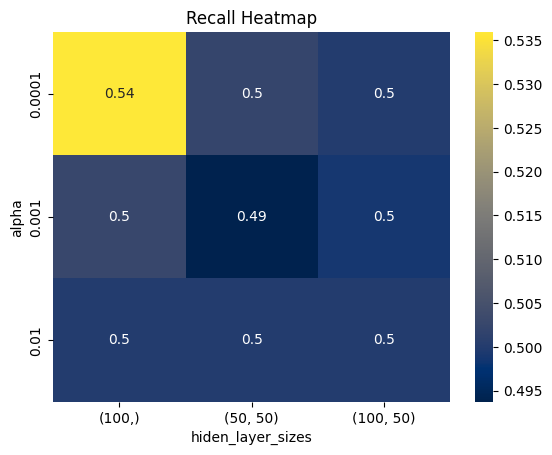

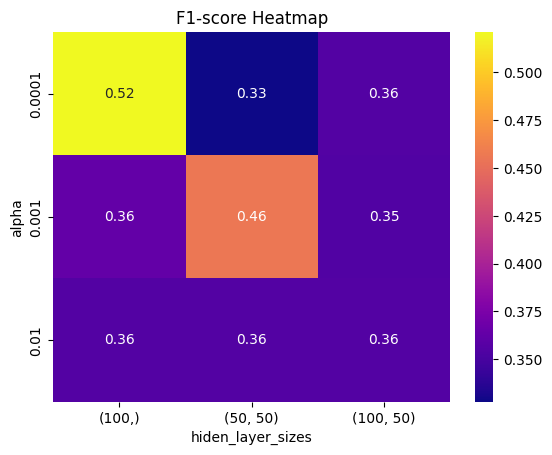

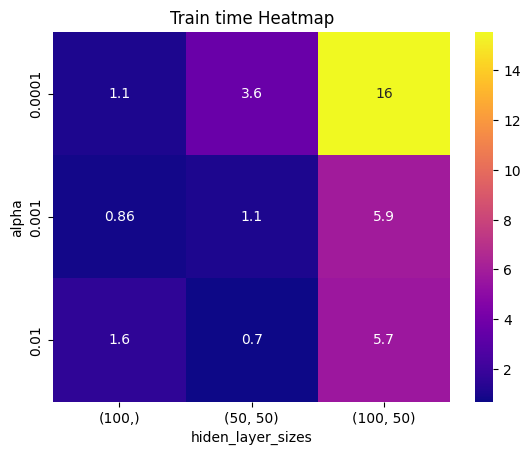

In [ ]:
# --- Heatmap ---
# --- Heatmap Accuracy ---
sns.heatmap(accuaracy_matrix, annot=True, xticklabels=hiden_layer_sizes_values, yticklabels=alpha_values, cmap="viridis")
plt.xlabel("hiden_layer_sizes")
plt.ylabel("alpha")
plt.title("Accuracy Heatmap")
plt.show()

# --- Heatmap Precision ---
sns.heatmap(precision_matrix, annot=True, xticklabels=hiden_layer_sizes_values, yticklabels=alpha_values, cmap="magma")
plt.xlabel("hiden_layer_sizes")
plt.ylabel("alpha")
plt.title("Precision Heatmap")
plt.show()

# --- Heatmap Recall ---
sns.heatmap(recall_matrix, annot=True, xticklabels=hiden_layer_sizes_values, yticklabels=alpha_values, cmap="cividis")
plt.xlabel("hiden_layer_sizes")
plt.ylabel("alpha")
plt.title("Recall Heatmap")
plt.show()

# --- Heatmap F1-score ---
sns.heatmap(f1_matrix, annot=True, xticklabels=hiden_layer_sizes_values, yticklabels=alpha_values, cmap="plasma")
plt.xlabel("hiden_layer_sizes")
plt.ylabel("alpha")
plt.title("F1-score Heatmap")
plt.show()

# --- Heatmap time ---
sns.heatmap(train_time_matrix, annot=True, xticklabels=hiden_layer_sizes_values, yticklabels=alpha_values, cmap="plasma")
plt.xlabel("hiden_layer_sizes")
plt.ylabel("alpha")
plt.title("Train time Heatmap")
plt.show()

# MATRICES DE CONFUSION

In [ ]:
for key, matrix in conf_matrices.items():
    print(f"alpha={key[0]}, hidden_layer_sizes={key[1]}")
    print(matrix)
    print("-------------")

alpha=0.0001, hidden_layer_sizes=(100,)
[[340 485]
 [229 444]]
-------------
alpha=0.0001, hidden_layer_sizes=(50, 50)
[[ 16 809]
 [ 10 663]]
-------------
alpha=0.0001, hidden_layer_sizes=(100, 50)
[[825   0]
 [673   0]]
-------------
alpha=0.001, hidden_layer_sizes=(100,)
[[823   2]
 [668   5]]
-------------
alpha=0.001, hidden_layer_sizes=(50, 50)
[[659 166]
 [546 127]]
-------------
alpha=0.001, hidden_layer_sizes=(100, 50)
[[823   2]
 [673   0]]
-------------
alpha=0.01, hidden_layer_sizes=(100,)
[[825   0]
 [673   0]]
-------------
alpha=0.01, hidden_layer_sizes=(50, 50)
[[825   0]
 [673   0]]
-------------
alpha=0.01, hidden_layer_sizes=(100, 50)
[[825   0]
 [673   0]]
-------------


# Probar validacion cruzada en cada modelo

In [ ]:
modelo1 = modelos_dict['activate=relu_alpha=0.0001_hiden_layer_sizes=(50, 50)']
modelo2 = modelos_dict['activate=relu_alpha=0.01_hiden_layer_sizes=(100,)']
modelo3 = modelos_dict['activate=relu_alpha=0.001_hiden_layer_sizes=(100, 50)']
resultado1 = validar_modelo_cv(modelo1, x, y, metric='accuracy', cv=5)
resultado2 = validar_modelo_cv(modelo2, x, y, metric='accuracy', cv=5)
resultado3 = validar_modelo_cv(modelo3, x, y, metric='accuracy', cv=5)

print(resultado1)
print(resultado2)
print(resultado3)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

{'Promedio': np.float64(0.7693591455273698), 'Desviacion': np.float64(0.024673424589350065), 'Tiempo_entrenamiento': 62.14725732803345}
{'Promedio': np.float64(0.7314419225634179), 'Desviacion': np.float64(0.03164359790233209), 'Tiempo_entrenamiento': 45.243051528930664}
{'Promedio': np.float64(0.775634178905207), 'Desviacion': np.float64(0.024355668459288427), 'Tiempo_entrenamiento': 152.01326942443848}


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
